<a href="https://colab.research.google.com/github/mrrkdas/Mini-Projects/blob/main/GAN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All the code here is based off of the [tensorflow article](https://www.tensorflow.org/tutorials/generative/dcgan) on GANs

In [2]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## Getting the Data

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
train_images.shape[0]

60000

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
train_images = (train_images - 127.5) / 127.5

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-07-27 15:20:44.666897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Creating the models


In [8]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Checking if the reshape worked

  model.add(layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 7, 7, 128) # Checking if Conv2DTranspose Layer worked
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias = False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides =(2,2), padding = 'same', use_bias = False, activation = 'tanh' ))
  assert model.output_shape == (None, 28, 28, 1)

  return model

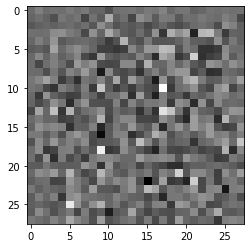

In [9]:
# Create an image
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0, :,:, 0], cmap = 'gray')

In [10]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = [28,28,1]))

  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [11]:
# Using Generated image in discriminator model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00157217]], shape=(1, 1), dtype=float32)


## Loss Calculation

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [13]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

In [14]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer 

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define Training Loop

In [17]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [18]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function

def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    real_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)


    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [22]:
train(train_dataset, EPOCHS)

KeyboardInterrupt: 